In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer

# ---------------- 1. 加载数据 ----------------
df_trainers = pd.read_excel('New_User.xlsx')
df_behavior = pd.read_csv('user_behavior.csv')
df_filter   = pd.read_csv('user_filter.csv')

trainer_ids = df_trainers['trainer_id'].astype(str).values
user_ids    = df_filter['user_id'].astype(str).values
n_trainers  = len(trainer_ids)
n_users     = len(user_ids)

# ---------------- 2. 用户行为分 ----------------
w_click, w_watch, w_like = 0.3, 0.6, 0.1
df_behavior['trainer_id'] = df_behavior['trainer_id'].astype(str)
df_behavior['user_id']    = df_behavior['user_id'].astype(str)
df_behavior['score'] = (
    w_click * df_behavior['click'] +
    w_watch * df_behavior['watch'] +
    w_like * df_behavior['like']
)
rating_matrix = df_behavior.pivot_table(
    index='user_id', columns='trainer_id',
    values='score', fill_value=0
).reindex(index=user_ids, columns=trainer_ids, fill_value=0)
R = rating_matrix.values  # (n_users, n_trainers)

# ---------------- 3. 内容分：标签匹配+平台分 ----------------
df_trainers['specialities'] = df_trainers['specialities'].fillna('').astype(str)
df_trainers['spec_list'] = df_trainers['specialities'].apply(lambda x: [s.strip() for s in x.split(',') if s.strip()])
mlb = MultiLabelBinarizer()
T_spec = mlb.fit_transform(df_trainers['spec_list'])
df_filter['goal_list'] = df_filter['goal_list'].fillna('').astype(str)
U_spec = MultiLabelBinarizer(classes=mlb.classes_).fit_transform(
    df_filter['goal_list'].apply(lambda x: [s.strip() for s in x.split(',') if s.strip()])
)
C1 = U_spec.dot(T_spec.T)
C1 = np.divide(C1, C1.max(axis=1, keepdims=True) + 1e-9)
fs = df_trainers['Final_Score'].fillna(0).values.astype(float)
fs_min, fs_max = fs.min(), fs.max()
FS = (fs - fs_min) / (fs_max - fs_min) if fs_max > fs_min else fs * 0
C2 = np.tile(FS, (n_users, 1))
w_c1, w_c2 = 0.6, 0.4
C_raw = w_c1 * C1 + w_c2 * C2

# ---------------- 4. Top-K Item-based 协同过滤分 ----------------
sim = cosine_similarity(R.T)  # (n_trainers, n_trainers)
K = 20
sim_topk = np.zeros_like(sim)
for i in range(sim.shape[0]):
    idx = np.argsort(-sim[i])[:K+1]  # topK+自己
    sim_topk[i, idx] = sim[i, idx]
mask = (R > 0).astype(float)
numerator   = R.dot(sim_topk)
denominator = mask.dot(sim_topk) + 1e-9
CF_raw = numerator / denominator

# ---------------- 5. 多级价格偏好分（四档） ----------------
price_col = 'Pricing' if 'Pricing' in df_trainers.columns else 'price'
price_bins = pd.qcut(df_trainers[price_col], 4, labels=False, duplicates='drop')  # 四分位分箱
P_raw = np.ones((n_users, n_trainers), dtype=float)
for u_idx, row in df_filter.iterrows():
    pref = str(row['filter_price']).lower()
    if 'low' in pref:
        P_raw[u_idx] = (price_bins.values == 0).astype(float)
    elif 'mid' in pref or 'med' in pref:
        P_raw[u_idx] = (price_bins.values == 1).astype(float)
    elif 'high' in pref:
        P_raw[u_idx] = (price_bins.values == 2).astype(float)
    else:  # 最高价
        P_raw[u_idx] = (price_bins.values == 3).astype(float)

# ---------------- 6. 标准化三路特征 ----------------
def minmax(mat):
    flat = mat.ravel()
    mn, mx = flat.min(), flat.max()
    return (mat - mn) / (mx - mn + 1e-9)
C  = minmax(C_raw)
CF = minmax(CF_raw)
P  = minmax(P_raw)

# ---------------- 7. 动态加权融合与推荐 ----------------
user_act_count = (R > 0).sum(axis=1)
final_scores = np.zeros_like(C)
for i in range(n_users):
    # 行为少/协同信息稀疏：内容分主导，否则均衡
    if user_act_count[i] < 3 or CF_raw[i].max() < 1e-6:
        w_c, w_cf, w_p = 0.7, 0.0, 0.3
    else:
        w_c, w_cf, w_p = 0.4, 0.4, 0.2
    final_scores[i] = w_c * C[i] + w_cf * CF[i] + w_p * P[i]

# ---------------- 8. Top10 推荐输出 ----------------
top10_idx = np.argpartition(-final_scores, kth=10, axis=1)[:, :10]
rows = []
for i, u in enumerate(user_ids):
    idxs = top10_idx[i]
    scores = final_scores[i, idxs]
    order = np.argsort(-scores)
    for rank in order:
        t = trainer_ids[idxs[rank]]
        sc = scores[rank]
        rows.append({'user_id': u, 'trainer_id': t, 'final_score': sc})

df_result = pd.DataFrame(rows)
df_result.to_csv('user_trainer_top10_improved.csv', index=False)
print("✔️ 改进后的推荐结果已保存到 user_trainer_top10_improved.csv")


✔️ 改进后的推荐结果已保存到 user_trainer_top10_improved.csv


In [7]:
import numpy as np
import pandas as pd

# 假设这些变量都已生成（见上文大代码段）
# C, CF, P: (n_users, n_trainers)
# R: (n_users, n_trainers) 原始评分矩阵（1有行为/正反馈，0无行为）

def recall_at_k(y_true, y_pred, k=10):
    # y_true, y_pred: (n_users, n_trainers)
    recalls = []
    for true_row, pred_row in zip(y_true, y_pred):
        true_set = set(np.where(true_row > 0)[0])
        top_k = np.argsort(-pred_row)[:k]
        hits = len(true_set & set(top_k))
        if len(true_set) > 0:
            recalls.append(hits / min(len(true_set), k))
    return np.mean(recalls)

def precision_at_k(y_true, y_pred, k=10):
    precisions = []
    for true_row, pred_row in zip(y_true, y_pred):
        true_set = set(np.where(true_row > 0)[0])
        top_k = np.argsort(-pred_row)[:k]
        hits = len(true_set & set(top_k))
        precisions.append(hits / k)
    return np.mean(precisions)

def ndcg_at_k(y_true, y_pred, k=10):
    ndcgs = []
    for true_row, pred_row in zip(y_true, y_pred):
        ideal_idx = np.argsort(-true_row)[:k]
        ideal_gains = true_row[ideal_idx]
        ideal_dcg = np.sum((2**ideal_gains - 1) / np.log2(np.arange(2, k + 2)))
        pred_idx = np.argsort(-pred_row)[:k]
        pred_gains = true_row[pred_idx]
        dcg = np.sum((2**pred_gains - 1) / np.log2(np.arange(2, k + 2)))
        ndcgs.append(dcg / (ideal_dcg + 1e-9) if ideal_dcg > 0 else 0)
    return np.mean(ndcgs)

def mrr_at_k(y_true, y_pred, k=10):
    mrrs = []
    for true_row, pred_row in zip(y_true, y_pred):
        true_set = set(np.where(true_row > 0)[0])
        top_k = np.argsort(-pred_row)[:k]
        rank = [i for i, idx in enumerate(top_k) if idx in true_set]
        if rank:
            mrrs.append(1.0 / (rank[0] + 1))
        else:
            mrrs.append(0)
    return np.mean(mrrs)

# 网格搜索权重
weights = []
for w_c in np.arange(0, 1.01, 0.2):
    for w_cf in np.arange(0, 1.01 - w_c, 0.2):
        w_p = 1 - w_c - w_cf
        if w_p < 0 or w_p > 1:
            continue
        weights.append((w_c, w_cf, w_p))

print("w_c, w_cf, w_p | Recall@10 | Precision@10 | NDCG@10 | MRR@10")
for w_c, w_cf, w_p in weights:
    scores = w_c * C + w_cf * CF + w_p * P
    recall = recall_at_k(R, scores, k=10)
    precision = precision_at_k(R, scores, k=10)
    ndcg = ndcg_at_k(R, scores, k=10)
    mrr = mrr_at_k(R, scores, k=10)
    print(f"w_c={w_c:.1f}, w_cf={w_cf:.1f}, w_p={w_p:.1f} | Recall@10: {recall:.4f}, Precision@10: {precision:.4f}, NDCG@10: {ndcg:.4f}, MRR@10: {mrr:.4f}")



w_c, w_cf, w_p | Recall@10 | Precision@10 | NDCG@10 | MRR@10
w_c=0.0, w_cf=0.0, w_p=1.0 | Recall@10: 0.0100, Precision@10: 0.0081, NDCG@10: 0.0077, MRR@10: 0.0195
w_c=0.0, w_cf=0.2, w_p=0.8 | Recall@10: 0.0741, Precision@10: 0.0549, NDCG@10: 0.0821, MRR@10: 0.1713
w_c=0.0, w_cf=0.4, w_p=0.6 | Recall@10: 0.0741, Precision@10: 0.0549, NDCG@10: 0.0821, MRR@10: 0.1713
w_c=0.0, w_cf=0.6, w_p=0.4 | Recall@10: 0.0748, Precision@10: 0.0550, NDCG@10: 0.0824, MRR@10: 0.1714
w_c=0.0, w_cf=0.8, w_p=0.2 | Recall@10: 0.0761, Precision@10: 0.0555, NDCG@10: 0.0837, MRR@10: 0.1724
w_c=0.0, w_cf=1.0, w_p=0.0 | Recall@10: 0.0645, Precision@10: 0.0435, NDCG@10: 0.1400, MRR@10: 0.4026
w_c=0.2, w_cf=0.0, w_p=0.8 | Recall@10: 0.0479, Precision@10: 0.0389, NDCG@10: 0.0404, MRR@10: 0.1042
w_c=0.2, w_cf=0.2, w_p=0.6 | Recall@10: 0.1253, Precision@10: 0.0968, NDCG@10: 0.1201, MRR@10: 0.2454
w_c=0.2, w_cf=0.4, w_p=0.4 | Recall@10: 0.1155, Precision@10: 0.0890, NDCG@10: 0.1175, MRR@10: 0.2401
w_c=0.2, w_cf=0.6, w_

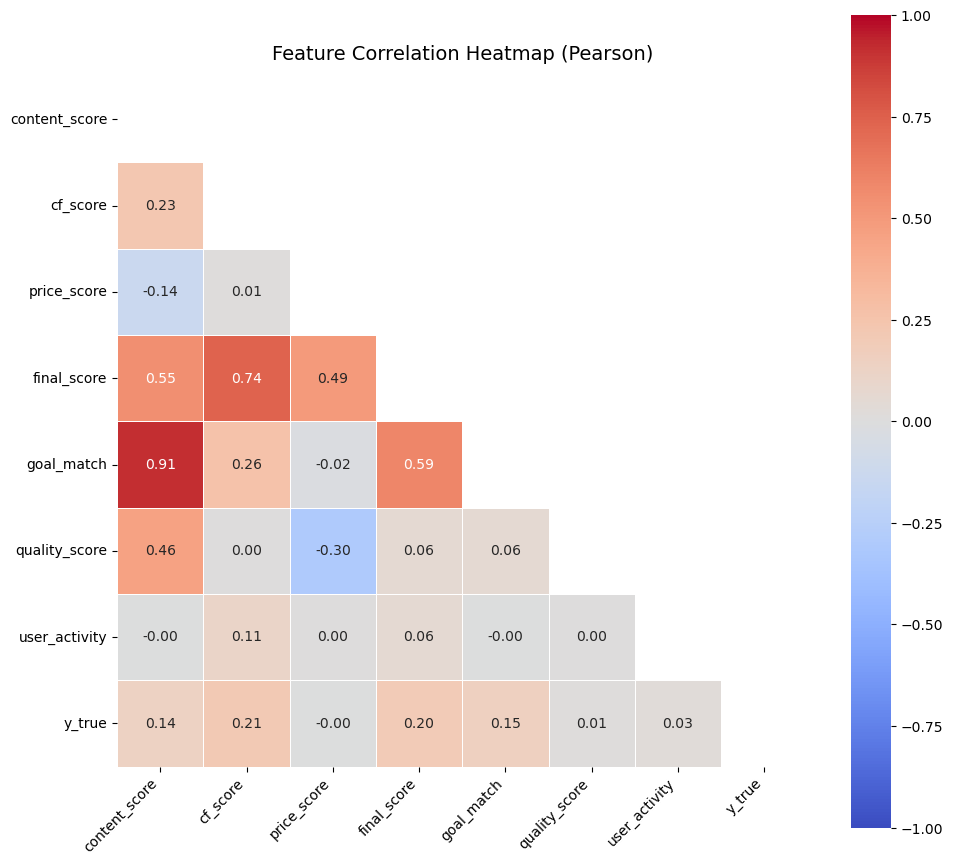

✅ 已保存：hybrid_feature_corr_heatmap.png


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ========= 前置：以下变量需已存在（来自你上面的混合模型代码） =========
# user_ids, trainer_ids: 1D array-like
# R:            (n_users, n_trainers)      # 行为得分矩阵（你前面构的）
# C1:           (n_users, n_trainers)      # 标签匹配分（行归一化后）
# FS:           (n_trainers,)              # 训练师质量/口碑 0~1
# C, CF, P:     (n_users, n_trainers)      # 三路特征，min-max 后
# final_scores: (n_users, n_trainers)      # 动态加权融合后
# user_act_count: (n_users,)               # 每个用户的历史行为数

# ========= 1) 生成特征表（抽样，避免过大内存） =========
n_users, n_items = C.shape
SAMPLE_N = 200_000                      # 抽样规模，可按需调大/调小
rng = np.random.default_rng(2025)

ui_idx = rng.integers(0, n_users, size=SAMPLE_N)
ij_idx = rng.integers(0, n_items, size=SAMPLE_N)

# 逐对取出各特征（注意 FS 只有按 item 取）
df_feat = pd.DataFrame({
    "content_score":     C[ui_idx, ij_idx],          # 内容分（融合了标签匹配与质量子因子后的）
    "cf_score":          CF[ui_idx, ij_idx],         # 协同过滤分
    "price_score":       P[ui_idx, ij_idx],          # 价格偏好分
    "final_score":       final_scores[ui_idx, ij_idx],# 融合总分（目标分）
    "goal_match":        C1[ui_idx, ij_idx],         # 标签匹配（行归一化后）
    "quality_score":     FS[ij_idx],                 # 质量/口碑（trainer 侧）
    "user_activity":     (user_act_count[ui_idx] / (user_act_count.max() + 1e-9)),  # 用户活跃度归一化
    "y_true":            (R[ui_idx, ij_idx] > 0).astype(float),   # 是否有正反馈（可换成 R 本身）
})

# 可选：把极端常数列/全零列去掉，防止相关性为 NaN
nz_cols = [c for c in df_feat.columns if df_feat[c].std() > 1e-12]
df_feat = df_feat[nz_cols]

# ========= 2) 计算相关系数（Pearson / Spearman） =========
METHOD = "pearson"   # 可改 "spearman"
corr = df_feat.corr(method=METHOD)

# ========= 3) 画热图（只显示下三角，更清爽） =========
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 9))
ax = sns.heatmap(
    corr, mask=mask,
    annot=True, fmt=".2f",
    cmap="coolwarm", vmin=-1, vmax=1, center=0,
    cbar=True, linewidths=0.5, linecolor="white", square=True
)
plt.title(f"Feature Correlation Heatmap ({METHOD.title()})", fontsize=14, pad=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("hybrid_feature_corr_heatmap.png", dpi=200)
plt.show()

print("✅ 已保存：hybrid_feature_corr_heatmap.png")
